## Project Description
The purpose of this project is to develop an RNN that can classify tweets based on whether they're describing a real disaster (1) or a fake disaster (0).

github link: https://github.com/lsiver/ml3_week4

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from PIL import Image as PILImage
from IPython.display import display
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_autotune_level=0'
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Cropping2D, CenterCrop, Embedding, Bidirectional, LSTM, TextVectorization, Dropout, SpatialDropout1D, GRU
from keras import layers
from keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from tensorflow.keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

## Data
Below I'm importing the data. There is a set of training texts, and tests texts. The `train` set has 7613 entries and 5 columns. The columns are `id`, `keyword`, `location`, `text`, and `target`. The `id` is simply an id locating the tweet. The `keyword` is a common keyword sourced from the `text`. The `text` is the tweet itself. The `location` is where the tweet was sent from. The `target` is whether the tweet is a legitimate disaster or not.

#### Data Size
The training set of tweets is ~**0.965MB** in size. 7613 entries, 5 columns.

The test set of tweets is ~**0.411MB** in size. 3263 entries, 4 columns.

In [4]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<hr>
The value counts of a true disaster (1) and a fake-disaster (0) are shown below. The skew is not so bad and should not be a concern for this classification problem.

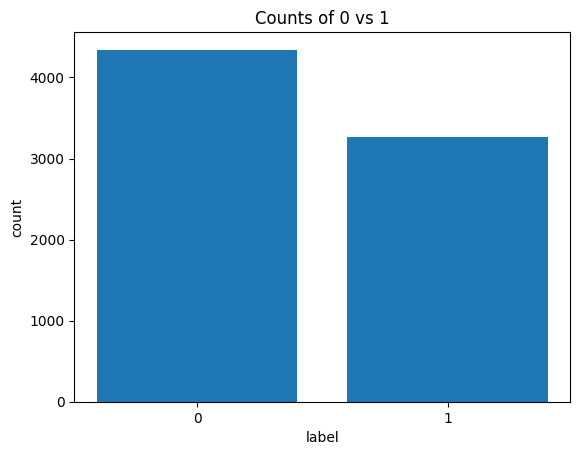

In [6]:
counts_01 = df['target'].value_counts()
plt.bar([0,1],counts_01.values)
plt.xlabel('label')
plt.xticks([0,1],['0','1'])
plt.ylabel('count')
plt.title('Counts of 0 vs 1')
plt.show()

The 10 LEAST frequent "words" are shown below. Many of these are not expected to add any value to the RNN problem (website links, tags @ to other users, etc). These will be removed and replaced with blank space. Hashtags such as "#calgary' will be replaced with the unhashed form 'calgary' for example

In [7]:
words = df['text'].str.lower().str.split().explode().dropna()
counts = words.value_counts()
print(counts.nsmallest(10))

text
#pandemonium.iso          1
@urufusanragu             1
@skynews                  1
http://t.co/dm0uupqgwy    1
mill.                     1
disclos...                1
http://t.co/ta6n9szyfp    1
jez                       1
printing                  1
news@@                    1
Name: count, dtype: int64


In [8]:
def cleaner(text):
    text = text.lower()
    text = re.sub(r'http\S+',"",text)
    text = re.sub(r'#(\w+)',r'\1',text)
    text = re.sub(r'@\w+',"",text)
    text = re.sub(r'\d+',"",text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), "",text)
    text = re.sub(r'\s+'," ",text).strip()
    return text
df['cleaned_text'] = df['text'].astype(str).apply(cleaner)
train_texts = df['cleaned_text'].values
df_test['cleaned_text'] = df_test['text'].astype(str).apply(cleaner)
test_texts = df_test['cleaned_text'].values

In [9]:
text_nulls = df_test['cleaned_text'].isna().sum()
print(text_nulls)

0


After cleaning the texts, the 10 least frequent words are shown below again. These are for the most part more reasonable and real words.

In [10]:
words = df['cleaned_text'].str.lower().str.split().explode().dropna()
counts = words.value_counts()
print(counts.nsmallest(10))

cleaned_text
knocks      1
hung        1
litany      1
slam        1
oversee     1
empower     1
annoyed     1
syd         1
traces      1
enduring    1
Name: count, dtype: int64


In [11]:
train_labels = df['target'].astype(int).values

### Data Null Entries
The null counts for `text`, `location` and `keyword` are shown below. The keyword and location nulls may need to be handled specifically if these are used in a neural network.

In [13]:
location_nulls = df['location'].isna().sum()
keyword_nulls = df['keyword'].isna().sum()
text_nulls = df['text'].isna().sum()
print(text_nulls,location_nulls,keyword_nulls)

0 2533 61


## Text Encoding

For the text to be usable in a neural network, the texts will need to be "encoded". Below, the `TextVectorization` will build a vocabulary of 10000 words (based on the frequency). The encoder will turn each input string into a sequence of integers, where each integer corresponds to a words appearance / position in the vocabulary. This function also automatically "pads" the length of any text strings to be equal to the largest length text string. Some RNN networks do not accept or work well with "jagged" texts where the lengths of each text are not equal.

The encoder is a layer that will be used in each RNN model's architecture.

In [14]:
encoder = TextVectorization(max_tokens = 10000)
encoder.adapt(train_texts)

I0000 00:00:1746411901.701415    4598 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [15]:
vocab = np.array(encoder.get_vocabulary())

An example of the encoder being used on a single tweet is shown below.

<hr>

In [16]:
encoded_example = encoder(train_texts)[:50].numpy()
print(train_texts[49])
print(encoded_example[49])

first night with retainers in its quite weird better get used to it i have to wear them every single night for the next year at least
[ 100  240   14 8755    4   37 1457 1539  429   48  556    5   15    8
   24    5 3376   91  198 1344  240   10    2  241  163   17  423    0
    0    0    0]


## RNN Model #1

The first model architecture attempted below is structured as such:

`encoder` -> `Embedding` -> `SpatialDropout1D` -> `LSTM` -> `Dense` -> `Dropout` -> `Dense`

The `encoder` layer encodes the text (as explained prior).

The `Embedding` layer converts the integer-encoded words into word vectors. Each word becomes a 64-dimensional vector. The dimensions are "features" of each word that the model learns. Words like fire and flame should have a very similar vector. 

The `SpatialDropout1D` layer is a regularization technique. It randomly drops entire words from the training.

`LSTM` is a special type of RNN that is made to remember important things and forget unimportant things.

`Dense` (64) is creating a simple linear with bias layer for every neuron.

`Dropout` is randomly dropping half of the neurons as a regularization technique.

`Dense` is the output layer, producing a logit that can be used to make predictions.

The `Adam` optimizer is being used. The training data with labels is split into a 80/20 training/test split inorder to monitor the validation loss as epochs are generated.

In [159]:
def make_model_1():
    model = keras.Sequential()
    model.add(encoder)
    model.add(Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.0)))
    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [160]:
model1 = make_model_1()
model1.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [161]:
history_1 = model1.fit(x=train_texts,y=train_labels,epochs=10,validation_split=0.2,batch_size = 10)

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6784 - loss: 0.5973 - val_accuracy: 0.7873 - val_loss: 0.4684
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8827 - loss: 0.3214 - val_accuracy: 0.7886 - val_loss: 0.4774
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9189 - loss: 0.2204 - val_accuracy: 0.7682 - val_loss: 0.5244
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.9470 - loss: 0.1586 - val_accuracy: 0.7354 - val_loss: 0.7076
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9661 - loss: 0.1046 - val_accuracy: 0.7525 - val_loss: 0.7259
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9705 - loss: 0.0732 - val_accuracy: 0.7466 - val_loss: 0.9515
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9756 - loss: 0.0597 - val_accuracy: 0.7420 - val_loss: 1.1053
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9733 - loss: 0.0604 - 

In [44]:
def plotter(history_in):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(history_in.history['accuracy'],    label='Train Acc')
    axs[0].plot(history_in.history['val_accuracy'], label='Valid. Acc')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training vs. Validation Accuracy')
    axs[0].legend()
    axs[1].plot(history_in.history['loss'],    label='Train Loss')
    axs[1].plot(history_in.history['val_loss'], label='Valid. Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training vs. Validation Loss')
    axs[1].legend()
    plt.show()

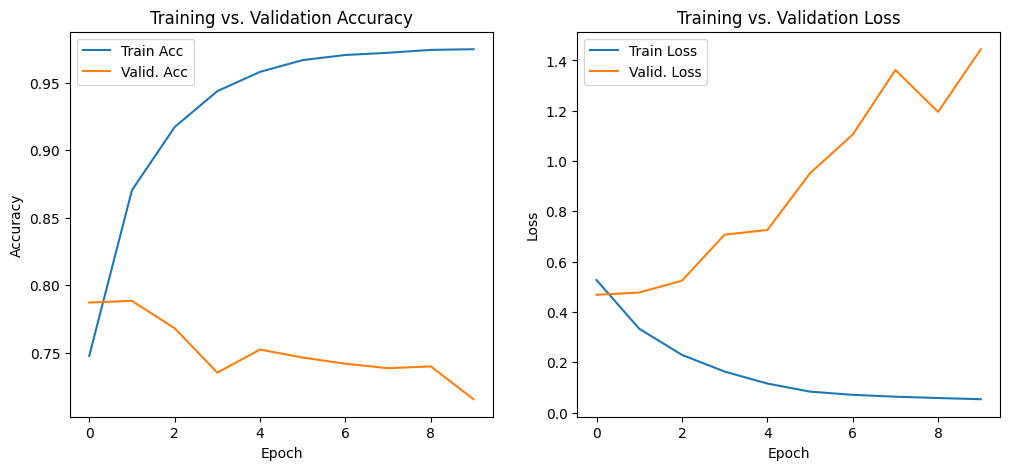

In [163]:
plotter(history_1)

In [164]:
model1 = make_model_1()
model1.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model1.fit(x=train_texts,y=train_labels,epochs=1)
preds = model1.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6617 - loss: 0.6058
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [165]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl1.csv', index=False)

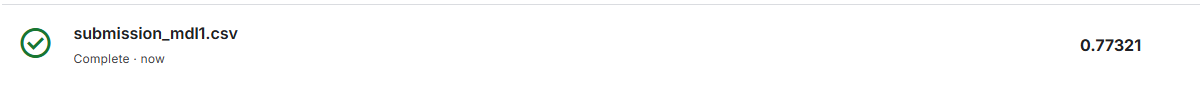

From the above graphs, it's clear that the model is overfitting immediately. Will attempt changing a few parameters and seeing if the results are much better.
`SpatialDropout1D` 0.2 -> 0.4
`recurrent_dropout` 0.0 -> 0.2
`LSTM` and `Dense` dims from 64 -> 32

In [166]:
def make_model_1():
    model = keras.Sequential()
    model.add(encoder)
    model.add(Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2,recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [167]:
model1_alt = make_model_1()
model1_alt.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [168]:
history_1 = model1_alt.fit(x=train_texts,y=train_labels,epochs=10,validation_split=0.2,batch_size = 50)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 223ms/step - accuracy: 0.6032 - loss: 0.6827 - val_accuracy: 0.7702 - val_loss: 0.5176
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.8437 - loss: 0.4262 - val_accuracy: 0.7919 - val_loss: 0.4622
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.8917 - loss: 0.3108 - val_accuracy: 0.7840 - val_loss: 0.4686
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.9170 - loss: 0.2555 - val_accuracy: 0.7669 - val_loss: 0.5199
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.9324 - loss: 0.2076 - val_accuracy: 0.7597 - val_loss: 0.5954
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.9414 - loss: 0.1715 - val_accuracy: 0.7610 - val_loss: 0.6390
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.9533 - loss: 0.1521 - val_accuracy: 0.7479 - val_loss: 0.6913
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.9607 - loss: 0

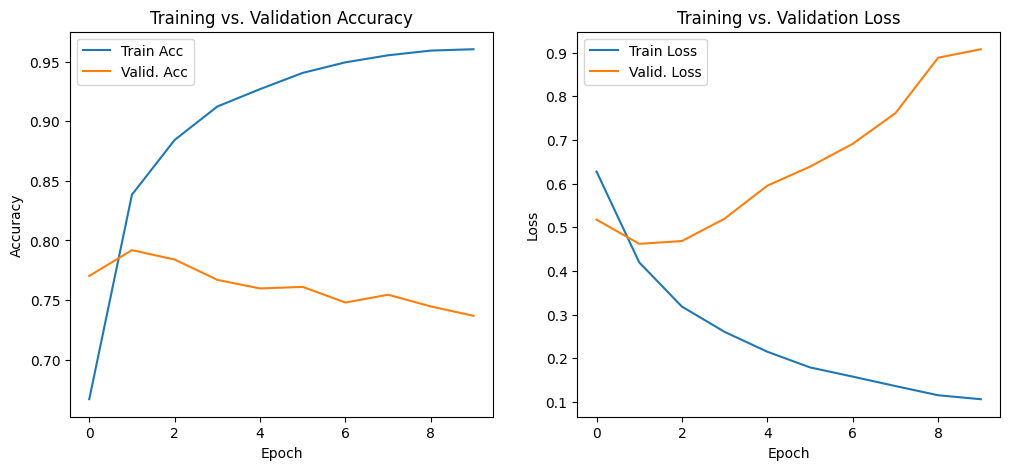

In [169]:
plotter(history_1)

In [170]:
model1_alt = make_model_1()
model1_alt.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model1_alt.fit(x=train_texts,y=train_labels,epochs=3)
preds = model1_alt.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 53s 207ms/step - accuracy: 0.5930 - loss: 0.6724
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.8467 - loss: 0.4083
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 49s 206ms/step - accuracy: 0.8890 - loss: 0.3190
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


In [171]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl1_alt.csv', index=False)

<hr>

The results are a little better. But the overfitting starts to occur pretty quickly right at epoch 1.

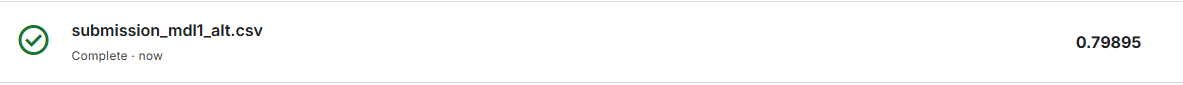

## RNN Model #2
The results above were pretty bad. It is possibly overfitting. Wondering if using `GRU` instead of `LSTM` will produce better results.

In [172]:
def make_model_2():
    model = keras.Sequential()
    model.add(encoder)
    model.add(Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=128,mask_zero=True))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.0,return_sequences=True,kernel_regularizer='l2',recurrent_regularizer='l2')))
    model.add(Bidirectional(GRU(32, dropout=0.2)))
    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [173]:
model2 = make_model_2()
model2.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [174]:
history_2 = model2.fit(x=train_texts,y=train_labels,epochs=10,validation_split=0.2,batch_size = 10)

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.6425 - loss: 1.3647 - val_accuracy: 0.7879 - val_loss: 0.4801
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8673 - loss: 0.3563 - val_accuracy: 0.7951 - val_loss: 0.4672
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9031 - loss: 0.2739 - val_accuracy: 0.7754 - val_loss: 0.5202
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9262 - loss: 0.2109 - val_accuracy: 0.7722 - val_loss: 0.5311
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9521 - loss: 0.1644 - val_accuracy: 0.7551 - val_loss: 0.6739
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9523 - loss: 0.1452 - val_accuracy: 0.7518 - val_loss: 0.6984
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9667 - loss: 0.1313 - val_accuracy: 0.7439 - val_loss: 0.7941
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9662 - loss: 0.1271 - 

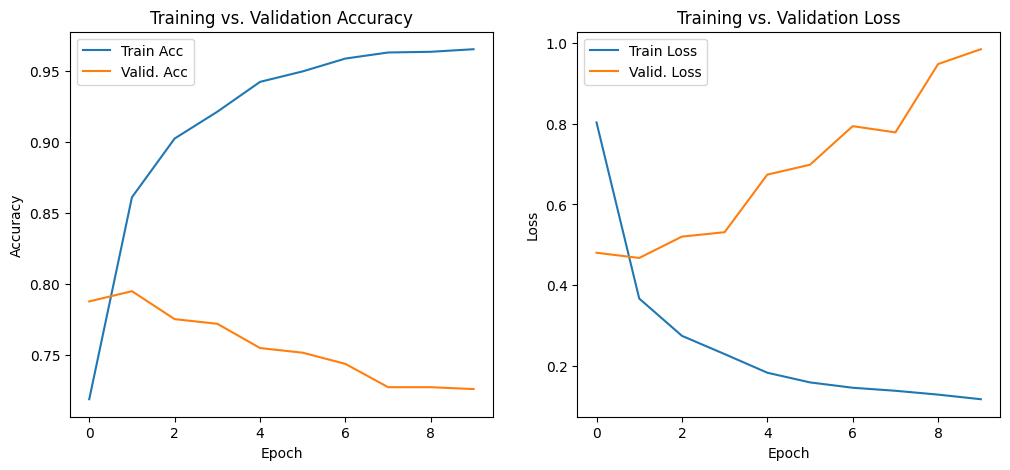

In [175]:
plotter(history_2)

In [176]:
model2 = make_model_1()
model2.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model2.fit(x=train_texts,y=train_labels,epochs=3)
preds = model2.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.6292 - loss: 0.6516
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 204ms/step - accuracy: 0.8502 - loss: 0.3864
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.8903 - loss: 0.3012
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [177]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl2.csv', index=False)

GRU is also overfitting very quickly. Not very good results.
Will make similar changes as I did to the LSTM model: `SpatialDropout1D` 0.2 -> 0.4
`recurrent_dropout` 0.0 -> 0.2
`LSTM` and `Dense` dims from 64 -> 32
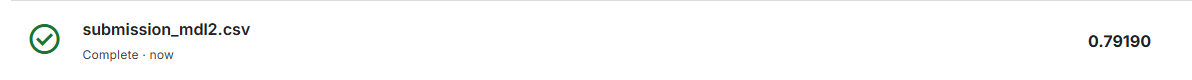
<hr>

In [178]:
def make_model_2():
    model = keras.Sequential()
    model.add(encoder)
    model.add(Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=128,mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add((GRU(32, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,kernel_regularizer='l2',recurrent_regularizer='l2')))
    model.add(GRU(32, dropout=0.2))
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [179]:
model2_alt = make_model_2()
model2_alt.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [180]:
history_2 = model.fit(x=train_texts,y=train_labels,epochs=10,validation_split=0.2,batch_size = 10)

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 110s 180ms/step - accuracy: 0.9610 - loss: 0.1275 - val_accuracy: 0.8910 - val_loss: 0.3648
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 109s 178ms/step - accuracy: 0.9651 - loss: 0.1236 - val_accuracy: 0.8798 - val_loss: 0.3410
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 110s 181ms/step - accuracy: 0.9696 - loss: 0.1114 - val_accuracy: 0.8621 - val_loss: 0.3739
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 106s 175ms/step - accuracy: 0.9721 - loss: 0.0942 - val_accuracy: 0.8674 - val_loss: 0.3823
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 109s 179ms/step - accuracy: 0.9722 - loss: 0.1060 - val_accuracy: 0.8562 - val_loss: 0.4172
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 108s 178ms/step - accuracy: 0.9671 - loss: 0.1161 - val_accuracy: 0.8516 - val_loss: 0.5490
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 109s 180ms/step - accuracy: 0.9778 - loss: 0.0843 - val_accuracy: 0.8542 - val_loss: 0.4429
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 108s 178ms/step - accuracy: 0.9729 -

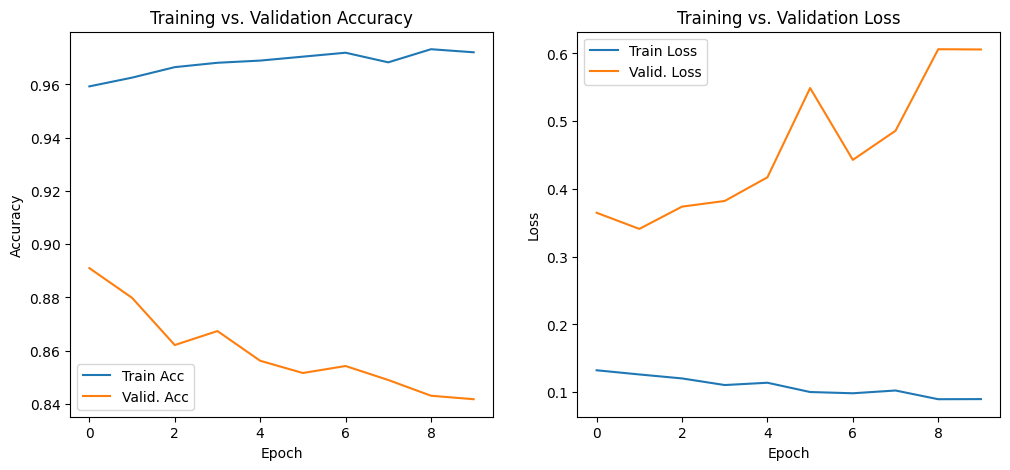

In [181]:
plotter(history_2)

In [182]:
model2_alt = make_model_2()
model2_alt.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model2_alt.fit(x=train_texts,y=train_labels,epochs=2)
preds = model2_alt.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

Epoch 1/2
238/238 ━━━━━━━━━━━━━━━━━━━━ 50s 195ms/step - accuracy: 0.6003 - loss: 1.3101
Epoch 2/2
238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.8448 - loss: 0.4088
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


In [183]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl2_alt.csv', index=False)

This looks just as bad as the model before it.
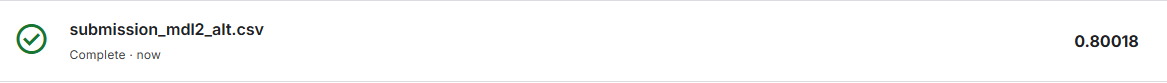

## Embeddings Change


The `Embeddings` layer in the architectures prior must develop its own word-vectors for every word based on the text samples given. There could be a significant benefit in using a pre-trained embeddings layer from an outside source that was trained on more twitter data. This will provide the model with accurate word vectors to start the modelling with. Words are already mapped into a space where similar meanings have similar vectors, such as "king" and "man" and "queen" and "woman".

The embeddings layer is taken from GloVe, is 100-dimensions for each word, and was specifically trained on many twitter tweets.

In [15]:
embeddings_index = {}
with open('glove.twitter.27B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
glove_embeddings = embeddings_index

In [20]:
vocab = encoder.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=None, 
    trainable=False,
    mask_zero=True
)

#### The two models below are GRU and LSTM, as before, but this time they will use the pre-calulated embeddings from GloVe

<hr>

## RNN Model #3 LSTM w/ GloVe

In [184]:
def make_model_3():
    model = keras.Sequential()
    model.add(encoder)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.0)))
    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [185]:
model3_LSTM = make_model_3()
model3_LSTM.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [186]:
history_3 = model3_LSTM.fit(x=train_texts,y=train_labels,epochs=20,validation_split=0.2,batch_size = 10)

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.7091 - loss: 0.5751 - val_accuracy: 0.8030 - val_loss: 0.4303
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7922 - loss: 0.4775 - val_accuracy: 0.8076 - val_loss: 0.4272
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8109 - loss: 0.4344 - val_accuracy: 0.8043 - val_loss: 0.4249
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8083 - loss: 0.4401 - val_accuracy: 0.8083 - val_loss: 0.4331
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8258 - loss: 0.4118 - val_accuracy: 0.7978 - val_loss: 0.4602
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8119 - loss: 0.4027 - val_accuracy: 0.8155 - val_loss: 0.4419
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8287 - loss: 0.3962 - val_accuracy: 0.8030 - val_loss: 0.4269
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8390 - loss: 0.3756 - 

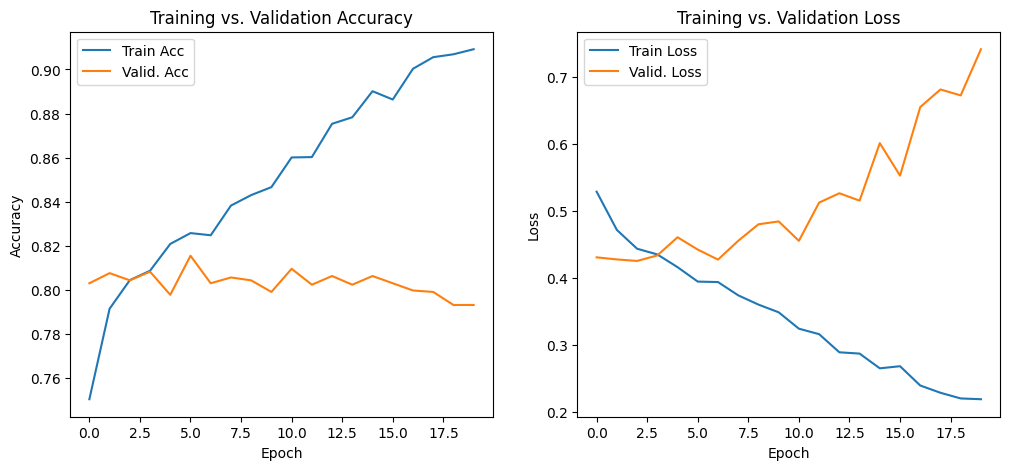

In [187]:
plotter(history_3)

In [188]:
model3_LSTM = make_model_2()
model3_LSTM.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model3_LSTM.fit(x=train_texts,y=train_labels,epochs=6)
preds = model3_LSTM.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

Epoch 1/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 49s 190ms/step - accuracy: 0.6011 - loss: 1.3154
Epoch 2/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.8545 - loss: 0.4019
Epoch 3/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.8924 - loss: 0.3054
Epoch 4/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step - accuracy: 0.9168 - loss: 0.2462
Epoch 5/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9320 - loss: 0.2065
Epoch 6/6
238/238 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.9382 - loss: 0.1887
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


In [190]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl3_LSTM.csv', index=False)

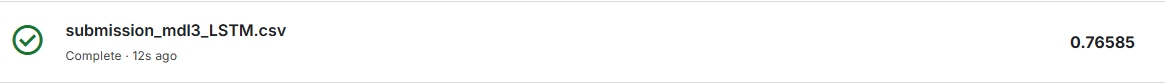

Not a significant change, at all. The validation loss begins at a minimum and increases epoch per epoch.

## RNN Model #4 GRU w/ GloVe

In [191]:
def make_model_4():
    model = keras.Sequential()
    model.add(encoder)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.0, return_sequences=True,
                                kernel_regularizer='l2', recurrent_regularizer='l2')))
    model.add(Bidirectional(GRU(32, dropout=0.2)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [192]:
model4_GRU = make_model_4()
model4_GRU.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [193]:
history_4 = model4_GRU.fit(x=train_texts,y=train_labels,epochs=20,validation_split=0.2,batch_size = 10)

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.6824 - loss: 1.4796 - val_accuracy: 0.8076 - val_loss: 0.4929
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.7710 - loss: 0.5434 - val_accuracy: 0.7997 - val_loss: 0.4668
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7767 - loss: 0.5153 - val_accuracy: 0.8168 - val_loss: 0.4556
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7908 - loss: 0.5008 - val_accuracy: 0.8102 - val_loss: 0.4553
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7753 - loss: 0.5178 - val_accuracy: 0.8109 - val_loss: 0.4419
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.7935 - loss: 0.4920 - val_accuracy: 0.8076 - val_loss: 0.4632
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7835 - loss: 0.5038 - val_accuracy: 0.8135 - val_loss: 0.4602
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7845 - loss: 0.4908 - 

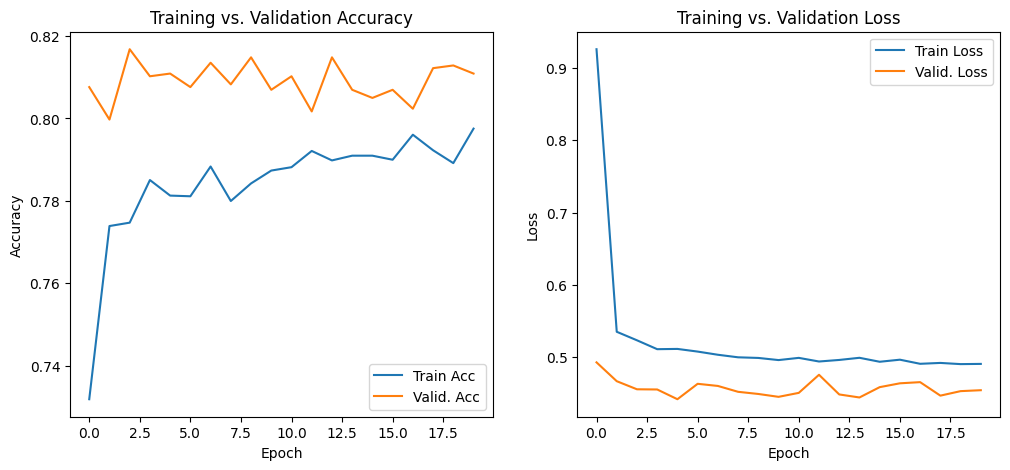

In [195]:
plotter(history_4)

In [197]:
model4_GRU = make_model_2()
model4_GRU.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy'])
model4_GRU.fit(x=train_texts,y=train_labels,epochs=4)
preds = model4_GRU.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

Epoch 1/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 49s 192ms/step - accuracy: 0.6001 - loss: 1.3151
Epoch 2/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.8461 - loss: 0.4151
Epoch 3/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.8829 - loss: 0.3274
Epoch 4/4
238/238 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.9099 - loss: 0.2587
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


In [198]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl4_GRU.csv', index=False)

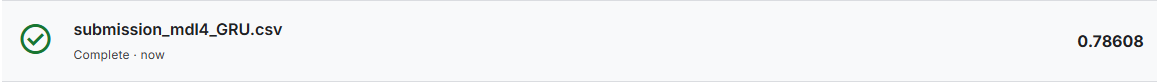

The validation loss graph is a little suspect. A mostly flat validation loss and training loss. That said, the kaggle test results are not that much better either and the actual value of the validation loss is near the minimum value that other models produced.

## RNN Model #5 - Slower Learning Rate Test

`Adam` optimizer usually works well out-of-the-box, but I will test slowing the learning rate and see if the overfitting problem was really an overfitting problem or if it is the nature of the data/models.

In [40]:

def make_model_5():
    model = keras.Sequential()
    model.add(encoder)
    model.add(Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.0,recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [41]:
model5 = make_model_5()
opt = Adam(learning_rate=5e-5)
model5.compile(
    loss='BinaryCrossentropy',
    optimizer=opt,
    metrics=['accuracy'])

In [42]:
history_5 = model5.fit(x=train_texts,y=train_labels,epochs=20,validation_split=0.2,batch_size = 10)

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5640 - loss: 0.7191 - val_accuracy: 0.5345 - val_loss: 0.7086
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5880 - loss: 0.6950 - val_accuracy: 0.5345 - val_loss: 0.6925
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6129 - loss: 0.6579 - val_accuracy: 0.7301 - val_loss: 0.6318
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7683 - loss: 0.5832 - val_accuracy: 0.7656 - val_loss: 0.5719
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8097 - loss: 0.5120 - val_accuracy: 0.7754 - val_loss: 0.5356
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8276 - loss: 0.4718 - val_accuracy: 0.7768 - val_loss: 0.5150
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8386 - loss: 0.4270 - val_accuracy: 0.7800 - val_loss: 0.5018
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8602 - loss: 0.3865 - val_ac

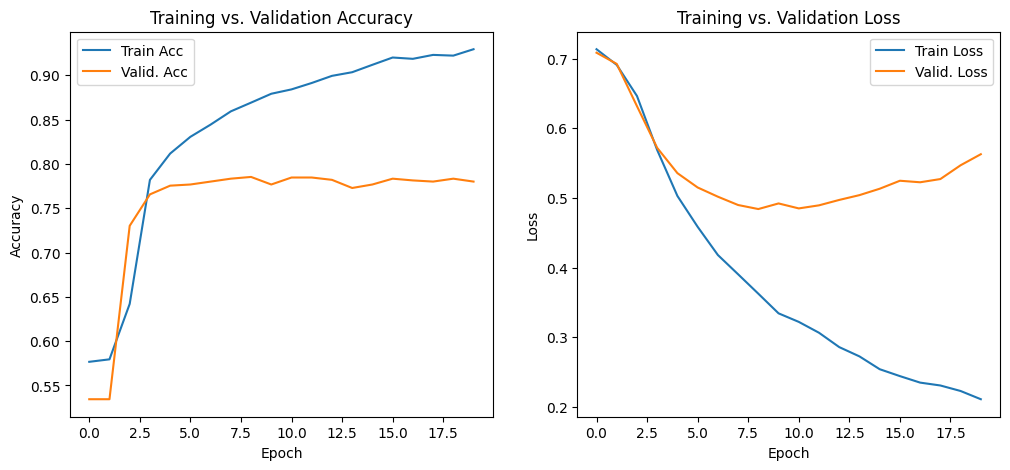

In [45]:
plotter(history_5)

Lowering the learning rate does push the validation loss minimum out a few epochs but if the model was truly overfitting due to a high learning rate, I also would have expected the minimum validation loss to be lower than any of the prior models. Here, it is ~0.5 which is higher than a few of the models. So essentially we've gained nothing but have slowed down the modelling process, unfortunately.

In [46]:
model5 = make_model_5()
opt = Adam(learning_rate=5e-5)
model5.compile(
    loss='BinaryCrossentropy',
    optimizer=opt,
    metrics=['accuracy'])
model5.fit(x=train_texts,y=train_labels,epochs=7)
preds = model5.predict(test_texts)
pred_class = (preds > 0.5).astype(int)
df_test['pred_labels'] = pred_class

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5410 - loss: 0.7228
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5688 - loss: 0.7144
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5688 - loss: 0.7048
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5789 - loss: 0.6884
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6786 - loss: 0.6459
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7824 - loss: 0.5772
Epoch 7/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8064 - loss: 0.5131
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [47]:
ids = df_test['id']
pred_labels = df_test['pred_labels']
submit_df = pd.DataFrame({
    'id':ids,
    'target':pred_labels
})
submit_df.head
submit_df.to_csv('data/submission_mdl5.csv', index=False)

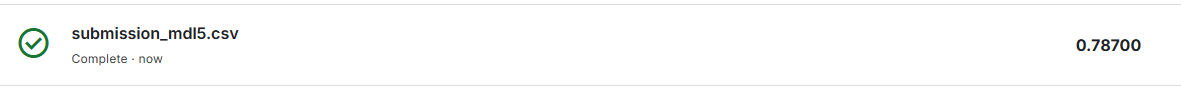

The results match what the validation accuracy predicted, around 0.78.

## Results
|Model|Accuracy|
|-|-|
|Model 1, LSTM|0.77|
|Model 1 LSTM w/ Regularization and less dims|0.80|
|Model 2, GRU| 0.79|
|Model 2, GRU w/ Regularization and less dims |0.80|
|Model 3, LSTM with GloVe Embeddings|0.77|
|Model 4, GRU with GloVe Embeddings|0.79|
|Model 5, GRU with slow learning rate|0.79|

The results across all of the models were pretty underwhelming. ~0.80 accuracy for about each of the different models. Changing the strength of the regularization and adjusting the dimensions did not significantly improve any of the models (but added significant compute time, from 30s -> 150s per epoch for barely any benefit).

It's very odd that across all of the different model architectures that the validation loss begins at its minimum and then immediately starts increasing. I would not expect a model to immediately begin overfitting at the beginning of its epochs.

Using the pre-trained GloVe embeddings did not increase the accuracy, either.

## Conclusions

A test/validation result of ~0.80 isn't terrible in its own right but it is disappointing that any attempts to improve it did not pan out.

I'm not entirely sure what would increase the results here. Maybe more efforts could be given to cleaning the texts better before using them in the training/modelling.

I had initially thought that the overfitting was due to a high learning rate, but when adjusting the learning rate to be much slower and then it did not reduce the minimum validation loss, this was ruled out. It looks odd that many of the graphs started out at the validation loss minimum but purposefully using a slow learning rate just to "push" this minimum out a few epochs without reducing the absolute minimum value is not a better model.



### References
https://www.kaggle.com/competitions/nlp-getting-started/overview

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://nlp.stanford.edu/projects/glove/